<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/main/get_results_and_features_stack_by_stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Response and Stimulus

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#imports
!pip install hdf5storage
import hdf5storage 
import pandas as pd
import numpy as np
from scipy import ndimage
from tqdm import notebook
from more_itertools import sliced
import matplotlib.pyplot as plt
import h5py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#declare the movie we're extracting in two parts, the date and fly index, and the mix desctiption
#we'll add the stack index inbetween when we extract the results
date_fly = '210815_0_'
movie_info = '_20220213T070259' # it looks like now carl is using more of a movie ID than discription

In [4]:
#This file contains the response and stimulus data for all stacks of this movie
#The movie id on the end corresponds with the same stacks in the results file

path = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Stimulus_Features/' + date_fly + 'stim' + movie_info + '_.mat'
#read file in using hdf5 structure
results_file = hdf5storage.loadmat(path)

In [4]:
#list the two main folders
list(results_file.keys())

['resp', 'stim1', 'stim2', 'stim3']

In [6]:
#the response and stimulus are now in a 1x(number of stacks) matrix
#Note that some stacks were split into two shorter stacks where Carl had to remove sections due to equipment interference (or something)
#There might be a different number of stacks here compared to the stackRaw's as a result
results_file['resp'].shape

(1, 10)

In [7]:
#each stack has a (# of rois) by (# of frames) matrix holding the fluorescence trace of the rois in that stack
for x in results_file['resp'][0]:
  print(x.shape)

(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)


In [8]:
#same for the stimulus values
for x in results_file['stim1'][0]:
  print(x.shape)

(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)


# Spatial footprints

### IMPORTANT! If Carl has split any of the stacks for the response and stimulus features, we need to go into the 'results' folder and make a copy of that stack's caiman results so that the number of spatial result files matches the number of stacks

### This is not an elegant solution, but it works

In [5]:
#Filter the files in the results folder down to the h5 files that match this movie, then reconstruct the paths
import os
root = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'
spatial_files = os.listdir(root)
spatial_files = [s for s in spatial_files if date_fly in s and '.h5' in s]
spatial_filepaths = [root + s for s in spatial_files]
spatial_filepaths

['/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_2_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_3_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_4_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_5_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_6_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/210815_0_7_stackRaw_mc_mix1_syt_result_20220213T070259.h5',
 '/content/drive/MyD

In [6]:
#to order the paths by the stack number, put them in a pandas df, extract the stack number from the name, and sort by the number
spatial_files_df = pd.DataFrame({
    'filename': spatial_files,
    'filepath': spatial_filepaths
})

#The filename starts with the date_flyIndex_stackIndex, so we split by "_" and take the 3rd segment (index 2)
spatial_files_df['stack_number'] = spatial_files_df['filename'].str.split('_', expand=True)[2].astype(int)

#sort by stack number to align the spatial files with the order of the stacks in the response and stimulus files
spatial_files_df = spatial_files_df.sort_values('stack_number', ascending=True)
spatial_files_df

,filename,filepath,stack_number
0,210815_0_1_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,1
1,210815_0_2_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,2
2,210815_0_3_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,3
3,210815_0_4_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,4
4,210815_0_5_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,5
5,210815_0_6_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,6
6,210815_0_7_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,7
7,210815_0_8_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,8
8,210815_0_9_stackRaw_mc_mix1_syt_result_2022021...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,9
9,210815_0_10_stackRaw_mc_mix1_syt_result_202202...,/content/drive/MyDrive/DS6011_Capstone_VisualN...,10


In [11]:
# test that we can access each spatial file by printing the shape of the first roi mask in each file
for x in spatial_files_df['filepath']:
  with h5py.File(x, 'r') as file:
    print(file['spatial'][0].shape)

(32768,)
(32768,)
(32768,)
(32768,)
(32768,)
(32768,)
(32768,)
(32768,)
(32768,)
(32768,)


In [12]:
#load all of the spatial matrices into memory for faster looping later - dictionary for now
spatial_matrices = {}
for stack_number in range(len(spatial_files_df)):
  with h5py.File(spatial_files_df['filepath'][stack_number], 'r') as file:
      spatial_matrices[stack_number] = file['spatial'][()].astype(bool).astype(int) #convert values to integer 0/1 representation of footprint

In [13]:
#double check the shape of the first stack's matrix - should be (# of rois) by (# of pixels)
spatial_matrices[0].shape

(15, 32768)

# Cell type labels

In [7]:
import pandas as pd

label_csv = pd.read_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/' + date_fly + 'label' + movie_info + '_.csv')
#Add a column that converts the index (0-index) to the roi number (1-index)
label_csv['roi_number'] = label_csv['index'] + 1
label_csv

,stack,index,label,roi_number
0,210815_0_1_stackRaw_mc_mix1_syt_,0,tm2,1
1,210815_0_1_stackRaw_mc_mix1_syt_,1,tm2,2
2,210815_0_1_stackRaw_mc_mix1_syt_,2,tm4,3
3,210815_0_1_stackRaw_mc_mix1_syt_,3,tm2,4
4,210815_0_1_stackRaw_mc_mix1_syt_,4,tm2,5
5,210815_0_1_stackRaw_mc_mix1_syt_,5,tm9,6
6,210815_0_1_stackRaw_mc_mix1_syt_,6,tm1,7
7,210815_0_1_stackRaw_mc_mix1_syt_,7,tm4,8
8,210815_0_1_stackRaw_mc_mix1_syt_,8,tm4,9
9,210815_0_1_stackRaw_mc_mix1_syt_,9,tm2,10


# Stimulus Data read and exploration

In [15]:
# stimulus_file = h5py.File(stimulus_path, 'r')
# stimulus_file['stimulus'].shape

In [16]:
# #plot the stimulus for the first roi for the first 200 frames
# #note that the matrix shape is flipped compared to the results matrices
# #need to access index zero with [:,0] rather than [0]
# plt.figure(figsize=(20,5))
# plt.plot(stimulus_file['stimulus'][:][:,0])

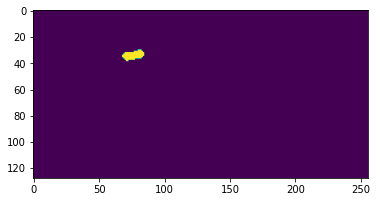

In [17]:
#plot the first roi of the first stack
dims = [128, 256]

plt.imshow(np.reshape(spatial_matrices[0][0], dims, order="F"))

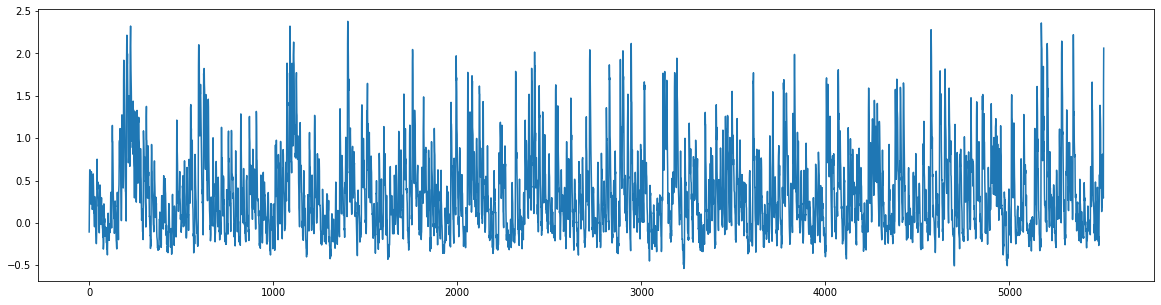

In [18]:
#visualize temporal traces - first roi
#indexing to the response subfolder, then into the array of stacks, then into the first stack, then into the first roi
temporal = results_file['resp'][0][0][0]
plt.figure(figsize=(20,5))
plt.plot(temporal)

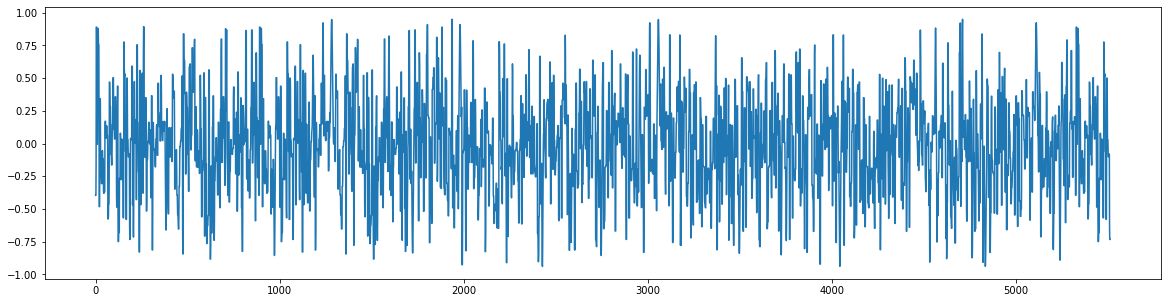

In [19]:
#visualize stimulus traces - first roi
#indexing to the response subfolder, then into the array of stacks, then into the first stack, then into the first roi
temporal = results_file['stim1'][0][0][0]
plt.figure(figsize=(20,5))
plt.plot(temporal)

# Extract features from each roi in the file

In [20]:
#IMPORTANT
#Set the time period in frames that we want to consider here
#If 1, then we're doing no temporal collapsing, just taking the fluorescence / stimulus
#if >1, then we return the mean, min, max fluorescence over chunks of that length

temporal_period_length = 20

#Calculate the number of stacks and the number of rois to loop through
num_stacks = len(results_file['resp'][0])
num_rois = len(results_file['resp'][0][0])
print(f"Extracting raw features for {num_rois} rois across {num_stacks} stacks")

Extracting raw features for 15 rois across 10 stacks


# Save Out Raw Data


In [8]:
keys = list(results_file.keys())
keys

['resp', 'stim1', 'stim2', 'stim3']

In [9]:
# make sure the shapes of each key match
for l in keys:
  print(results_file[l].shape)

(1, 10)
(1, 10)
(1, 10)
(1, 10)


In [10]:
# check that all data is the same size for each stack
for l in keys:
  print(l)
  for s in range(0,results_file[l].shape[1]): # loop through number of stacks
    print(results_file[l][0,s].shape) # prints shape of each stack
  print('----------')

resp
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
----------
stim1
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
----------
stim2
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
----------
stim3
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
(15, 5513)
----------


In [11]:
# this is just a reference to understand the path through the object
results_file[keys[0]][0,1][0].shape # first category, first stack, first roi, all the frames

(5513,)

In [12]:
test_labels = label_csv.drop(columns=['stack','index'])
test_labels

,label,roi_number
0,tm2,1
1,tm2,2
2,tm4,3
3,tm2,4
4,tm2,5
5,tm9,6
6,tm1,7
7,tm4,8
8,tm4,9
9,tm2,10


### Compile stimulus and labels into one dataframe

In [78]:
# compile into df

# save number of frames
num_frames = results_file[keys[0]][0,1][0].shape[0]

# get number of stacks
num_stacks = results_file[keys[0]].shape[1]

# get number of rois
num_rois = results_file[keys[0]][0,0].shape[0]
# -------------------------------------


# first create a table with stack, index, label, roi_number, and frame number to hold all the data
# create a df with a row for every frame
raw_data = pd.DataFrame({'frame': np.array(range(0,num_frames))})

# we will use the label_csv file to label all our data
# ASSUMPTION the labels are only given for the first stack, I'm assuming this is consistent for all the stacks in this group
# if the above is correct we will just multiply by 10.
# THIS WILL NEED TO CHANGE WHEN WE HAVE MULTIPLE VIDEOS !!!!!!!
full_labels = label_csv.drop(columns=['stack','index'])
spatials = spatial_files_df.drop(columns='filepath')
full_labels = spatials.merge(full_labels, how='cross')


# use a cross merge to get the cross product for this table and the full_labels
# this will give us a row for every frame for every roi in every stack
raw_data = full_labels.merge(raw_data, how='cross').rename(columns={'stack_number':'stack','roi_number':'roi'})
raw_data = raw_data.set_index(['filename','stack','label','roi','frame'])
raw_data

# note that frames start at 0 and roi's start at 1

Empty DataFrame
Columns: []
Index: [(210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 0), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 1), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 2), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 3), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 4), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 5), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 6), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 7), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 8), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 9), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 10), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 11), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 12), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 13), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 14), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 15), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 16), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 17), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 18), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 19), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 20), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 21), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 22), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 23), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 24), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 25), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 26), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 27), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 28), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 29), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 30), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 31), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 32), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 33), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 34), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 35), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 36), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 37), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 38), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 39), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 40), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 41), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 42), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 43), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 44), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 45), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 46), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 47), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 48), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 49), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 50), (210815_0_1_stackRaw_mc_mix1_syt_result_20220213T070259.h5, 1, tm2, 1, 51), (210815_0_1_stackRaw_m

In [79]:
# raw_data.groupby('filename').count()

In [80]:
# combine all stimulus data into one dataframe
import copy

stim_data = copy.deepcopy(results_file)
col = ['stack','roi', 'frame', 'l_label', 'stim_data']

# dataframe for stimulus data
s_df = pd.DataFrame(columns=col)
for l in keys:
  # flat_list = []

  # loop through all the stacks
  for s in range(0,num_stacks):
    # s_df = pd.DataFrame(columns=['stack','roi','resp','stim1','stim2','stim3'])
    # for r in range(0,num_rois):

    # create a 1D array for each column in df
    stim_data[l][0,s] = stim_data[l][0,s].reshape((num_rois * num_frames))
    stack = np.array([s + 1] * num_rois * num_frames)
    roi = np.array([[r] * num_frames for r in range(0,num_rois)]).flatten()
    frame_ind = np.array([list(range(0,num_frames)) * num_rois]).flatten()
    l_label = np.array([l] * num_rois * num_frames)

    # combine into 4D array
    data_array = np.stack((stack, roi, frame_ind, l_label, stim_data[l][0,s]), axis=1)
    
    # combine into df
    s_df = s_df.append(pd.DataFrame(columns=col, data=data_array)).astype({'stack': 'int32','roi': 'int32','frame': 'int32'})

# s_df = s_df.pivot(columns=['stack','roi','stim_data'], values='l_label') # this crashes (out of ram)
s_df

,stack,roi,frame,l_label,stim_data
0,1,0,0,resp,-0.10657514967308393
1,1,0,1,resp,0.24453468479729581
2,1,0,2,resp,0.39845828076023687
3,1,0,3,resp,0.619289719295058
4,1,0,4,resp,0.627614869474355
...,...,...,...,...,...
82690,10,14,5508,stim3,0.0
82691,10,14,5509,stim3,0.0891824148877678
82692,10,14,5510,stim3,0.019587992984614912
82693,10,14,5511,stim3,0.0


In [81]:
# combine stimulus data with raw data
raw_data = raw_data.reset_index()
for l in keys:
  raw_data = raw_data.merge(s_df[s_df.l_label == l],how='right',left_on=['stack','roi','frame'], right_on=['stack','roi','frame'])
  # name column after stimulus type
  raw_data = raw_data.rename(columns={'stim_data': l})

  # after adding to raw_data, drop data to save memory
  s_df = s_df[s_df.l_label != l]

  raw_data = raw_data.drop(columns=['l_label'])

raw_data# = raw_data.drop(['stack','roi'])

,filename,stack,label,roi,frame,resp,stim1,stim2,stim3
0,NaN,1,NaN,0,0,-0.10657514967308393,-0.39587710301081336,160.44796007284108,0.11006292345226329
1,NaN,1,NaN,0,1,0.24453468479729581,-0.39587710301081336,0.0,0.0
2,NaN,1,NaN,0,2,0.39845828076023687,-0.39587710301081336,0.0,0.0
3,NaN,1,NaN,0,3,0.619289719295058,-0.1386990083588493,170.25267562410147,0.03079015591058295
4,NaN,1,NaN,0,4,0.627614869474355,0.8900133702490065,-62.485103558137816,0.12213394090231325
...,...,...,...,...,...,...,...,...,...
826945,210815_0_10_stackRaw_mc_mix1_syt_result_202202...,10,tm2,14,5508,0.5786043895975522,0.11387414266081408,0.0,0.0
826946,210815_0_10_stackRaw_mc_mix1_syt_result_202202...,10,tm2,14,5509,0.417370999486442,-0.289958017275614,-96.52264627685145,0.0891824148877678
826947,210815_0_10_stackRaw_mc_mix1_syt_result_202202...,10,tm2,14,5510,0.3241708404200459,-0.3707244492628995,-89.79934745759641,0.019587992984614912
826948,210815_0_10_stackRaw_mc_mix1_syt_result_202202...,10,tm2,14,5511,0.25503262136292565,-0.3707244492628995,0.0,0.0


In [85]:
raw_data.to_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/' + \
                      date_fly + movie_info  + 'RAW_stimulus_data.csv')

## !! need to decide how to handle indexing for stacks that have been split. Right now this treats the split as two different stacks and we end up with more stacks than originally recorded ( 10 original stacks, one was split, now we have 11)

In [ ]:
dims = [128,256]

#loop through the stacks
for stack_index in notebook.tqdm(range(num_stacks), desc='stack', position=0):

  #open the corresponding spatial file and grab the spatial matrix
  spatial_matrix = spatial_matrices[stack_index]
  
  #grab the corresponding response matrix from the results file
  response_matrix = results_file['resp'][0][stack_index]

  #grab the corresponding stimulus 1 matrix
  stim1_matrix = results_file['stim1'][0][stack_index]
  
  #set up different dataframes depending on if we're collpsing temporal features or not
  if temporal_period_length == 1:

    roi_features = pd.DataFrame(columns =['roi_ID',
                                        'area',
                                        'center_of_mass_row',
                                        'center_of_mass_column',
                                        'resp',
                                        'stim1',
                                        'label',
                                        'frame_number'])
    
  else:
    roi_features = pd.DataFrame(columns =['roi_ID',
                                      'area',
                                      'center_of_mass_row',
                                      'center_of_mass_column',
                                      'mean_resp',
                                      'min_resp',
                                      'max_resp',
                                      'mean_stim1',
                                      'min_stim1',
                                      'max_stim1',
                                      'label',
                                      'start_frame_number'])

  #loop through rois in each file and extract features
  for roi_index in notebook.tqdm(range(num_rois), desc='roi', position=1, leave=False):

    roi_spatial = spatial_matrix[roi_index] #spatial footprint of the x'th roi
    roi_response = response_matrix[roi_index] #temporal trace of the x'th roi
    roi_stim1 = stim1_matrix[roi_index] #stim1 feature for the x'th roi
    roi_label = label_csv['label'][roi_index] #cell type label of the x'th roi
    #comcatenated ID for the roi - date, fly index, stack number, roi index, mix
    roi_ID = date_fly + str(stack_index + 1) + "_" + str(roi_index) + movie_info 

    #calculate spatial measures for this roi
    area = np.sum(roi_spatial)
    spatial_img = np.reshape(roi_spatial, dims, order="F")
    center_of_mass_row, center_of_mass_column = ndimage.center_of_mass(spatial_img)
    
    #If one sample is one frame, no temporal slicing necessary
    if temporal_period_length == 1:

      #loop through all frames in the stack for both stimulus and response
      for frame in range(len(roi_response)):

        response = roi_response[frame] #loop through frames
        stim1 = roi_stim1[frame] #and loop through stimulus

        roi_features = roi_features.append({'roi_ID': roi_ID,
                                            'area': area,
                                            'center_of_mass_row': center_of_mass_row,
                                            'center_of_mass_column': center_of_mass_column,
                                            'resp': response,
                                            'stim1': stim1,
                                            'label': roi_label,
                                            'frame_number': frame}, ignore_index=True)
        
    else:

      #list of lists containing the sliced up fluorescence values, one chunk has the length set in temporal_period_length
      response_slices = list(sliced(roi_response, temporal_period_length))
      stim1_slices = list(sliced(roi_stim1, temporal_period_length))

      #loop through slices and extract collapsed temporal features for each slice
      for temporal_slice in notebook.tqdm(range(len(response_slices)), desc='frame slices', position=2, leave=False):

        #check if we're at the end of a stack by checking how many frames are in the chunk
        #if the length of this chunk is the full length we expect, continue
        if len(response_slices[temporal_slice]) == temporal_period_length:

          start_frame_number = temporal_period_length * temporal_slice

          mean_resp = np.mean(response_slices[temporal_slice]) #loop through frames
          min_resp = np.min(response_slices[temporal_slice])
          max_resp = np.max(response_slices[temporal_slice])

          mean_stim1 = np.mean(stim1_slices[temporal_slice]) #loop through frames
          min_stim1 = np.min(stim1_slices[temporal_slice])
          max_stim1 = np.max(stim1_slices[temporal_slice])

          roi_features = roi_features.append({'roi_ID': roi_ID,
                                              'area': area,
                                              'center_of_mass_row': center_of_mass_row,
                                              'center_of_mass_column': center_of_mass_column,
                                              'mean_resp': mean_resp,
                                              'min_resp': min_resp,
                                              'max_resp': max_resp,
                                              'mean_stim1': mean_stim1,
                                              'min_stim1': min_stim1,
                                              'max_stim1': max_stim1,
                                              'label': roi_label,
                                              'start_frame_number': start_frame_number}, ignore_index=True)
          

  print(f"saving {len(roi_features)} records to {'/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/' + \
                      date_fly + str(stack_index +1) + movie_info + str(temporal_period_length)  + 'frameWindow_rawExtract.csv'}")  
        
  #save the features - uses the file info declared at the top, , the stack number, and the temporal window
  roi_features.to_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/' + \
                      date_fly + str(stack_index +1) + movie_info + str(temporal_period_length)  + 'frameWindow_rawExtract.csv')

stack:   0%|          | 0/11 [00:00<?, ?it/s]

roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_1_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_2_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_3_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_4_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_5_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_6_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_7_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_8_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

frame slices:   0%|          | 0/45 [00:00<?, ?it/s]

saving 660 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_9_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

frame slices:   0%|          | 0/177 [00:00<?, ?it/s]

saving 2640 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_10_mc_mix1_syt_20frameWindow_rawExtract.csv


roi:   0%|          | 0/15 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

frame slices:   0%|          | 0/265 [00:00<?, ?it/s]

saving 3960 records to /content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_11_mc_mix1_syt_20frameWindow_rawExtract.csv
